# Predicting Programming Languages using NLP

#### by Mariam Naqvi and Cindy Villanueva
#### August 3, 2021

### Executive Summary

- Our goal is to create a classification model to predict programming languages using Readme content from GitHub repositories.
    - This can assist users in finding relevant content based on their programming language critera.
    

### Key Takeaways

- Most common programming language found in our dataset is Javascript followed by Python
- Some of the most common words in Readmes were found to be: 'file', 'end', 'class','use' and 'object'.
- The length of the readme's varies by programming languages.
- 
- Our best model used  to predict programming languages with % accuracy. This model outperformed my baseline score of % accuracy, so it has value.

### Project Overview

- Trello board used to identify the different tasks for this project. You can find the board <a href="https://trello.com/b/PddXdOTJ/nlp-project">here</a>
- Python scripts were used to acquire, prepare and explore the data
- 
- Statistical analyses tested the following hypotheses:
    1. 
 
### Data Dictionary

The data dictionary detailing all variables utilized in this analyses can be found <a href="https://github.com/mariam-and-cindy/predicting-programming-languages/blob/main/README.md">here</a>.

In [1]:
# required imports

from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud


import prepare as pr


In [2]:
import explore as ex

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.linear_model import LogisticRegression


In [5]:
import model as mo

In [6]:
from sklearn.dummy import DummyClassifier


# Acquire

Our data was scraped from 400 GitHub repositories. We decided to use the list of most forked repos on GitHub <a href="https://github.com/search?o=desc&p={i}&q=stars%3A%3E1&s=forks&type=Repositories">here</a> for our dataset. 

This list of repositories was cached as a csv after acquisition and using our acquire script we pulled the username and title, language and readme contents of every repository into a json file. We converted the json file to a csv and will read that into a pandas dataframe.


In [7]:
# acquire the data
df = pd.read_csv('git_data.csv', index_col=0)

In [8]:
# quick look at df
df.head()

,repo,language,readme_contents
0,jtleek/datasharing,NaN,How to share data with a statistician\n=======...
1,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...
2,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...
3,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www...."
4,SmartThingsCommunity/SmartThingsPublic,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...


In [9]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             400 non-null    object
 1   language         344 non-null    object
 2   readme_contents  400 non-null    object
dtypes: object(3)
memory usage: 12.5+ KB


## Takeaways

- The dataset has 400 scraped repositories 
- Some Repositories are missing the language
    - This could be because no primary programming language was obvious
    - We will drop these rows during data preparation
- All variables are object dtypes
- language is our target variable

# Prepare

During this stage of the pipeline, we will work on cleaning and preparing the data for exploration and modeling. The prepration functions are part of the prepare script which will be imported. 

The following steps will be performed to create the best performing model:

- drop duplicate rows
- clean content to remove any special characters and certain words
- removestop words
- lemmatize content
- stemm content
- remove repos that have non English content
- drop rows with missing values
- create the following new columns
    - cleaned
    - stemmed
    - lemmatized 

In [10]:
# call the prepare function from the script
df = pr.prepare_mf(df)

In [11]:
# look at the prepare df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             180 non-null    object
 1   language         180 non-null    object
 2   readme_contents  180 non-null    object
 3   clean            180 non-null    object
 4   stemmed          180 non-null    object
 5   lemmatized       180 non-null    object
dtypes: object(6)
memory usage: 8.6+ KB


- To prevent data leakage, we will split our dataframe and perform exploration only on the train split. The function to split the dataet will be called from the prepare script. 

In [12]:
# call split function
train, validate, test = pr.split_data(df,'language')

complete df -> (180, 6)
train -> (100, 6)
validate -> (44, 6)
test -> (36, 6)


# Explore

We used our train split to explore the data. During exploration, we analyzed the data to answer the following questions:

- What are the most common words in READMEs?
- What does the distribution of IDFs look like for the most common words?
- Does the length of the README vary by programming language?
- Do different programming languages use a different number of unique words?

### What are the most common words in READMEs?


In [13]:
# find the different langauges in the train split
lang_vc = train.language.value_counts()


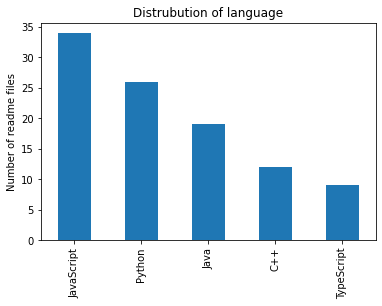

In [14]:
# visualize language value counts
lang_vc.plot(kind='bar')
plt.title('Distrubution of language')
plt.ylabel('Number of readme files')
plt.show()

In [15]:
# change value counts to list of languages
list_lang = list(train.language.value_counts().index)

In [16]:
# join all the text of each language
join_text ={}
for language in list_lang :
    join_text[language] = pr.basic_clean(' '.join(train[train.language == language].lemmatized))

# add all words 
join_text['all_words']= pr.basic_clean(' '.join(train.lemmatized))

In [17]:
# check if we have all the languages
join_text.keys()

dict_keys(['JavaScript', 'Python', 'Java', 'C++', 'TypeScript', 'all_words'])

- We will represent text as frequencies for each word to see which words are the most common. 

In [18]:
# create a word_count df
word_counts= pd.DataFrame()
for lang in join_text:
    word_counts[lang] = pd.Series(join_text[lang].split()).value_counts()
word_counts= word_counts.fillna(0).astype(int)

In [19]:
# sort word counts by all words and view the top 30 highest word frequencies
word_counts.sort_values('all_words', ascending=False).head(30)


,JavaScript,Python,Java,C++,TypeScript,all_words
python,2,472,5,23,0,502
library,37,344,4,34,12,431
td,211,0,174,0,0,385
learning,6,367,1,10,1,385
data,38,319,8,4,10,379
code,120,131,34,38,43,366
machine,9,348,0,6,0,363
eta,344,1,0,0,0,345
use,138,74,36,42,39,329
width100px,151,0,172,0,0,323


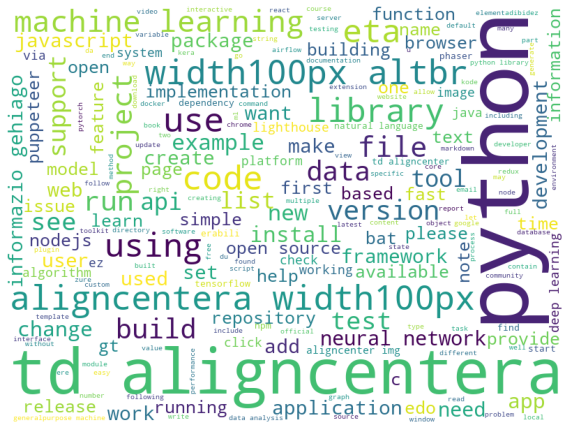

In [20]:
# visualize all the most common words as a word cloud
ex.word_cloud(join_text['all_words'])

 ********************* Language : JavaScript *********************


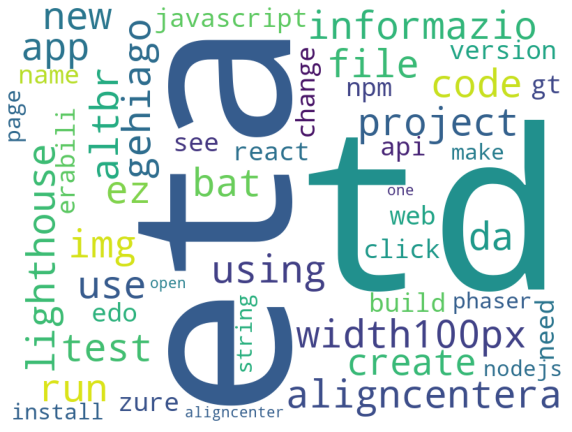

 
 ********************* Language : Python *********************


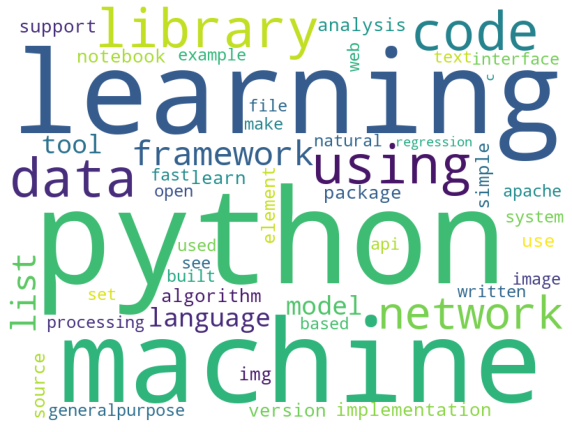

 
 ********************* Language : Java *********************


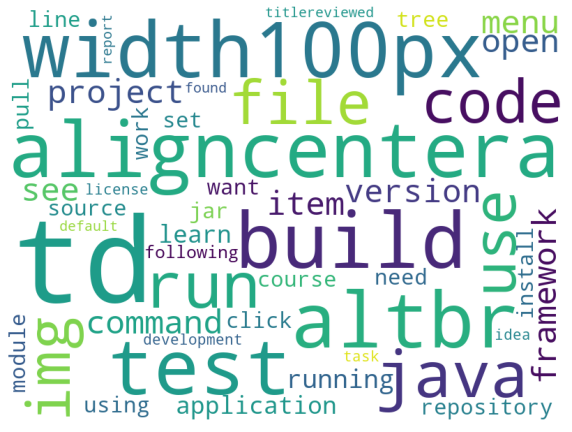

 
 ********************* Language : C++ *********************


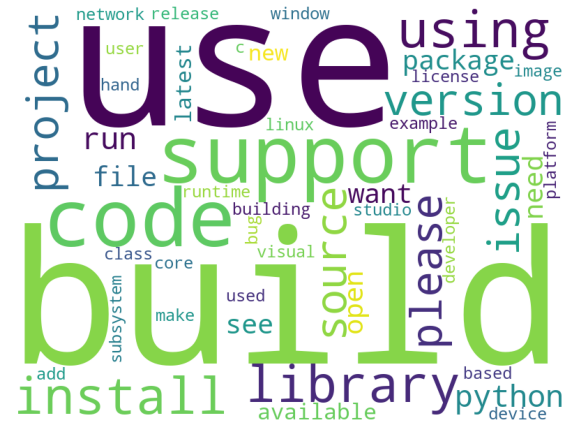

 
 ********************* Language : TypeScript *********************


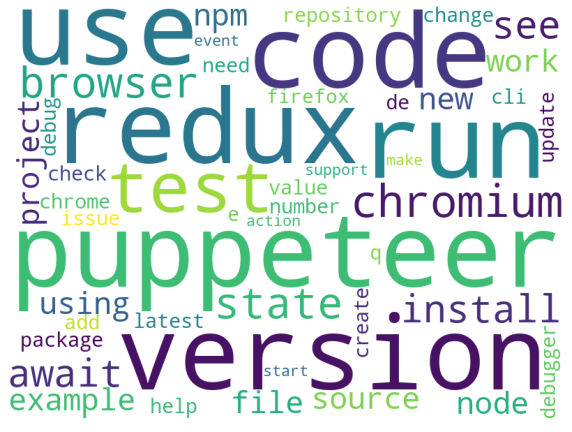

 
 ********************* Language : all_words *********************


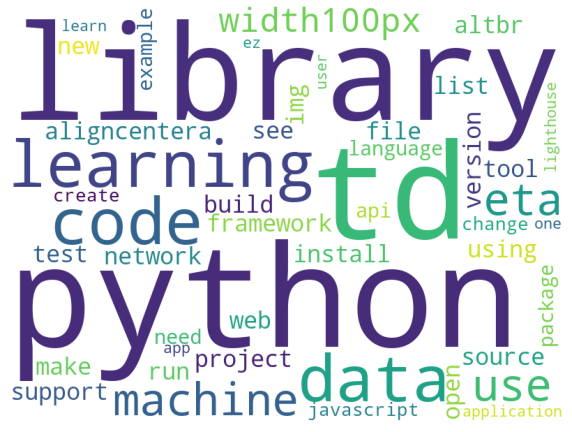

In [21]:
# visualize most frequently occurring words in each language

for col in word_counts.columns:
    print (f' ********************* Language : {col} *********************')
    ex.wordcloud_top(word_counts, col)
    print(' ')

## Takeaways

- Javascript is the most common language followed by Python
- python is the most frequently occurring word
    - It occurs in all languages except Typescript
- Java and Javascript have similar words

### What does the distribution of IDFs look like for the most common words?

In [22]:
# Get a list of the unique words
unique_words = pd.Series(' '.join(join_text.values()).split()).unique()

In [23]:
unique_words

array(['lint', 'disable', 'opensource', ..., 'fraudulent', 'fraud',
       'deem'], dtype=object)

In [24]:
def idf(word):
    n_occurences = sum([1 for doc in join_text.values() if word in doc])
    return len(join_text) / n_occurences

In [25]:
# put the unique words into a data frame
idf_df =(pd.DataFrame(dict(word=unique_words))
# calculate the idf for each word
.assign(idf=lambda train: train.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False))

In [26]:
idf_df.head()

,idf
word,
deem,3.0
20x,3.0
zippy,3.0
gbps,3.0
150000,3.0


- The most common words have an idf of 1.0 while unique words have an idf of 5.0.

In [27]:
# let's look at the most common words idf =1
idf_df[idf_df.idf==1].head()

,idf
word,
standing,1.0
counter,1.0
ram,1.0
andr,1.0
che,1.0


In [28]:
# in all the words, look at words that have an idf of 1
len(idf_df[idf_df.idf==1])

873

In [29]:
# all the words in the df 
len(idf_df)


12420

In [30]:
# proportion of most common words
len(idf_df[idf_df.idf==1]) /len(idf_df)


0.07028985507246377

- 7% of words have an idf of 1.0 indicating they are the most common words.

In [31]:
idf_df.groupby(idf).count()

,idf
1.0,873
1.2,523
1.5,735
2.0,1369
3.0,8920


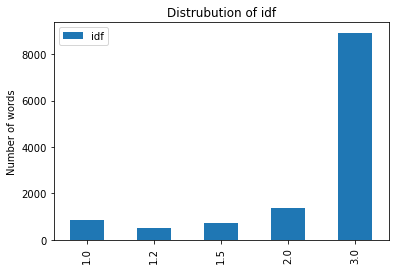

In [32]:
# visualize 
idf_df.groupby(idf).count().plot.bar()
plt.title('Distrubution of idf')
plt.ylabel('Number of words')
plt.show()

## Takeaways

- Most common words have an idf of 1.0
    - These words are only 7% of all the words
- The most unique words have an idf of 3.0 and make up most of the words 

### Does the length of the README vary by programming language?

In [33]:
# create a column for readme length in each of the splits
train['readme_length'] = train.lemmatized.apply(len)

validate['readme_length'] = validate.lemmatized.apply(len)

test['readme_length'] = test.lemmatized.apply(len)

In [34]:
# check training split
train.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,readme_length
38,microsoft/vscode,TypeScript,"# Visual Studio Code - Open Source (""Code - OS...",visual studio code open source code repository...,visual studio code open sourc code repositori ...,visual studio code open source code repository...,2196
32,nodejs/node,JavaScript,<!--lint disable no-literal-urls-->\n<p align=...,lint disable opensource crossplatform javascri...,lint disabl opensourc crossplatform javascript...,lint disable opensource crossplatform javascri...,5720
150,goldbergyoni/nodebestpractices,JavaScript,[✔]: assets/images/checkbox-small-blue.png\n\n...,nodejsren praktika img srcassetsimagesbanner2j...,nodejsren praktika img srcassetsimagesbanner2j...,nodejsren praktika img srcassetsimagesbanner2j...,82873
26,macrozheng/mall,Java,"# mall\n\n<p>\n <a href=""#公众号""><img src=""http...",hrefimg hrefimg 1 2 3 spring cloud hoxton 4 5 ...,hrefimg hrefimg 1 2 3 spring cloud hoxton 4 5 ...,hrefimg hrefimg 1 2 3 spring cloud hoxton 4 5 ...,763
56,home-assistant/core,Python,Home Assistant |Chat Status|\n================...,home assistant chat source home automation put...,home assist chat sourc home autom put local co...,home assistant chat source home automation put...,513


In [35]:
# find the readme length by programming language
train.groupby('language').readme_length.mean().sort_values(ascending=False)


language
Python        6513.461538
JavaScript    6073.500000
TypeScript    3388.111111
C++           3030.333333
Java          2147.421053
Name: readme_length, dtype: float64

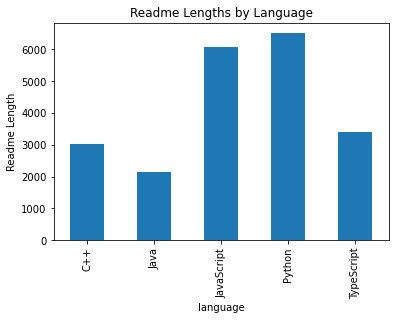

In [36]:
train.groupby('language').readme_length.mean().plot.bar()
plt.title('Readme Lengths by Language')
plt.ylabel('Readme Length')
plt.show()

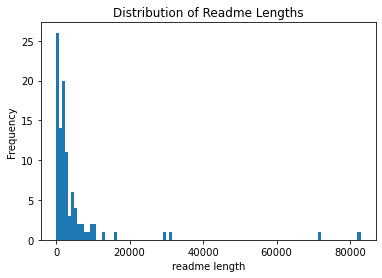

In [37]:
# visualize distribution of readme lengths
train.readme_length.plot.hist(bins=100)
plt.title('Distribution of Readme Lengths')
plt.xlabel('readme length')
plt.show()

(0.0, 16000.0)

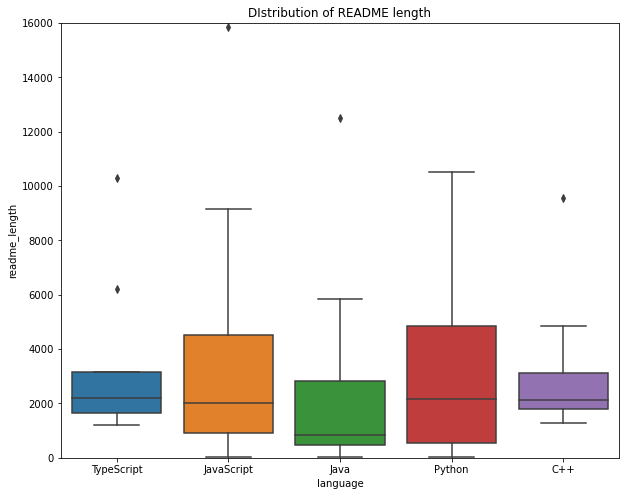

In [38]:
plt.figure(figsize= (10,8))
sns.boxplot(x='language',y ='readme_length', data= train)
plt.title('DIstribution of README length')
plt.ylim(0, 16000)

## Takeaways

- The readme length varies by programming language.
- Python has the longest average readme length followed by Javascript.
- Java has the shortest average readme length.
- Most readme's have lengths shorter than 10,000.
- There are some outliers with readme lengths over 20,000.


### Do different programming languages use a different number of unique words?

In [39]:
uniq_words={}
# Get a list of the unique words by language
for key in join_text:
    uniq_words [key] = list(pd.Series(join_text[key].split()).unique())

In [40]:
uniq_words.keys()


dict_keys(['JavaScript', 'Python', 'Java', 'C++', 'TypeScript', 'all_words'])

******************************UNIQUE WORDS FOR JavaScript ***************************** 


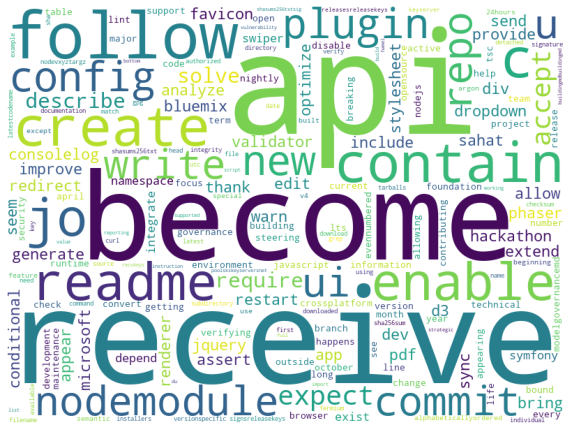

******************************UNIQUE WORDS FOR Python ***************************** 


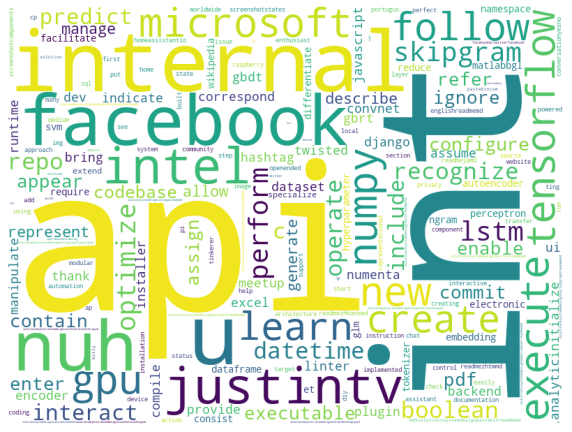

******************************UNIQUE WORDS FOR Java ***************************** 


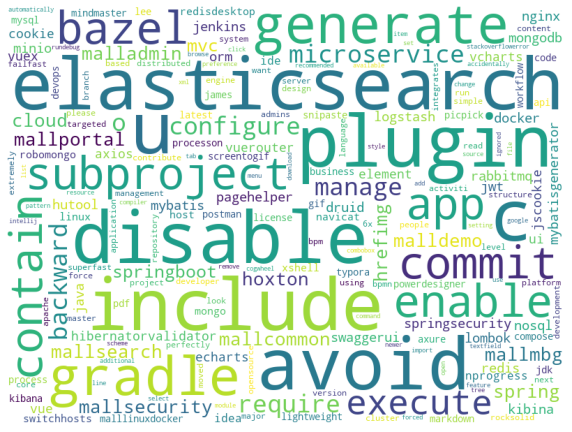

******************************UNIQUE WORDS FOR C++ ***************************** 


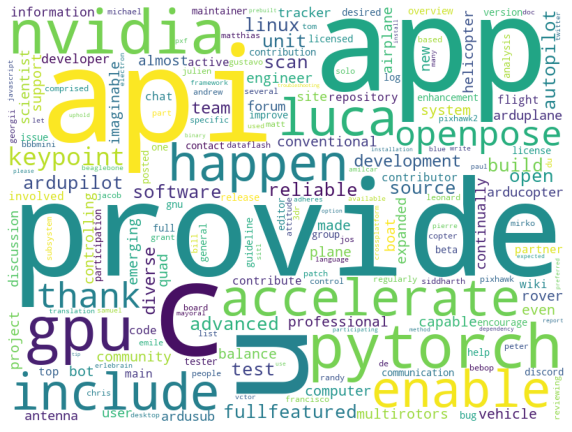

******************************UNIQUE WORDS FOR TypeScript ***************************** 


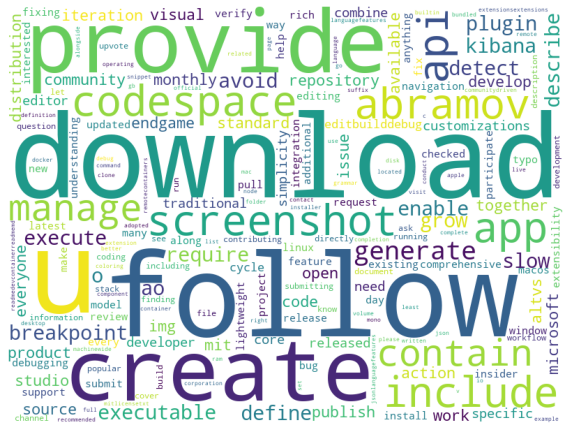

******************************UNIQUE WORDS FOR all_words ***************************** 


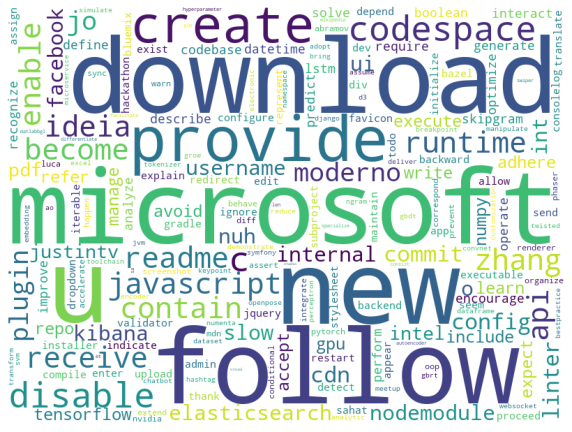

In [41]:
for key in uniq_words:    
    print(f'******************************UNIQUE WORDS FOR {key} ***************************** ')
    ex.word_cloud (' '.join(uniq_words[key]))

In [42]:
# create a dictionary of how many unique words each language has in their readme files
len_uniq_df={}
for key in uniq_words:
    len_uniq_df[key] = len(uniq_words[key])

In [43]:
# create a df of unique words by language
unique_by_lang = pd.DataFrame(len_uniq_df, index= ['unique_words'])

In [44]:
unique_by_lang

,JavaScript,Python,Java,C++,TypeScript,all_words
unique_words,7414,4736,1747,1847,1513,12420


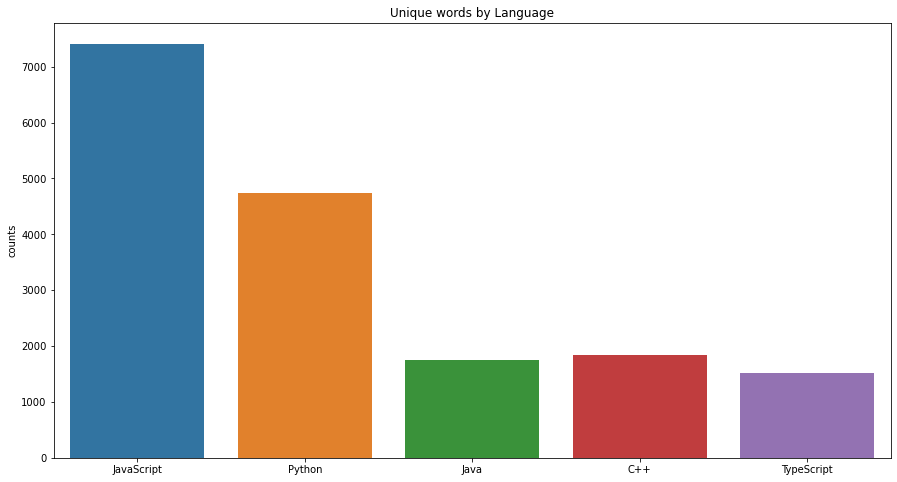

In [45]:
# visualize the unique words in each language
plt.figure(figsize= (15,8))
sns.barplot(data=unique_by_lang.drop(columns=['all_words']))
plt.ylabel('counts')
plt.title("Unique words by Language")
plt.show()

## Takeaways

- Javascript has the most unique words despite not having the longest Readme's
- Java, C++ and TypeScfript have quite similar number of unique words

# Model

We will use bag of words to create models since we plan to add ngrams to the models. We will focus on overall accuracy for model evaluation.

In [46]:
cv = CountVectorizer()
X = cv.fit_transform(train.lemmatized)
y = train.language

In [47]:
# split X and y using function from the modeling script
X_train, y_train, X_validate, y_validate, X_test, y_test = mo.nlp_xy_split (X,y)

X_train -> (56, 12390)               y_train->(56,)
X_validate -> (24, 12390)         y_validate->(24,) 
X_test -> (20, 12390)                  y_test>(20,)


In [48]:
# create a df to store metrics for each model
metric_df =pd.DataFrame(columns= ['model_name', 'train_score', 'validate_score'])

In [49]:
# look at empty metric df
metric_df


,model_name,train_score,validate_score


## Setting the Baseline

This baseline is what our models will intend to outperform. If a model beats the baseline, that indicates there is value in creating that particular model. We will check for the most common language in our train split and use that as the baseline.

In [50]:
#look at most common language
y_train.value_counts()


JavaScript    19
Python        15
Java          10
C++            7
TypeScript     5
Name: language, dtype: int64

In [51]:
# create the object
baseline = DummyClassifier(strategy='constant', constant='JavaScript')

#fit the object
baseline.fit(X_train, y_train)

# accuracy
base_acc = baseline.score(X_train, y_train)

In [52]:
# add baseline to metric df
metric_df =metric_df.append({'model_name': 'baseline', 'train_score': base_acc}, ignore_index = True)


In [53]:
metric_df

,model_name,train_score,validate_score
0,baseline,0.339286,NaN


## Model 1: Decision Tree



In [54]:
# fit the selected model
d_tree = DecisionTreeClassifier(max_depth=5)
model = d_tree.fit(X_train, y_train)

In [55]:
# using a function from model script
res = mo.compare_train_val(model,'train',X_train, y_train,'validate', X_validate, y_validate, 'dec_tree')


    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  78.60%              |                Overall Accuracy:  58.30%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,6,0,0,1,0
a_Python,0,5,0,5,0
a_Java,0,0,16,3,0
a_C++,0,0,0,15,0
a_TypeScript,0,0,0,3,2
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,0,2,0,1
a_Python,0,3,1,1,0
a_Java,0,0,6,2,0
a_C++,1,0,0,5,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,1.000000,0.857143,0.923077,7.000000
Java,1.000000,0.500000,0.666667,10.000000
JavaScript,1.000000,0.842105,0.914286,19.000000
Python,0.555556,1.000000,0.714286,15.000000
TypeScript,1.000000,0.400000,0.571429,5.000000
accuracy,0.785714,0.785714,0.785714,0.785714
macro avg,0.911111,0.719850,0.757949,56.000000
weighted avg,0.880952,0.785714,0.786983,56.000000
,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,3.000000


In [56]:
# add metrics
metric_df = metric_df.append(res, ignore_index = True)
metric_df


,model_name,train_score,validate_score
0,baseline,0.339286,NaN
1,dec_tree,0.786000,0.583


## Model 2: Naive_Bayes

In [57]:
# fit the object
nb= MultinomialNB(alpha= 0.5, fit_prior= False )
model2 =nb.fit(X_train, y_train)

In [58]:
# compare train and validate accuracy scores
res = mo.compare_train_val(model2,'train',X_train, y_train,'validate', X_validate, y_validate, 'naive_bayes')



    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  98.20%              |                Overall Accuracy:  45.80%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,7,0,0,0,0
a_Python,0,9,1,0,0
a_Java,0,0,19,0,0
a_C++,0,0,0,15,0
a_TypeScript,0,0,0,0,5
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,1,0,2,0,0
a_Python,0,0,4,1,0
a_Java,0,0,7,0,1
a_C++,2,0,1,3,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,1.000000,1.000000,1.000000,7.000000
Java,1.000000,0.900000,0.947368,10.000000
JavaScript,0.950000,1.000000,0.974359,19.000000
Python,1.000000,1.000000,1.000000,15.000000
TypeScript,1.000000,1.000000,1.000000,5.000000
accuracy,0.982143,0.982143,0.982143,0.982143
macro avg,0.990000,0.980000,0.984345,56.000000
weighted avg,0.983036,0.982143,0.981902,56.000000
,precision,recall,f1-score,support
C++,0.333333,0.333333,0.333333,3.000000


In [59]:
# add metrics
metric_df = metric_df.append(res, ignore_index = True)
metric_df

,model_name,train_score,validate_score
0,baseline,0.339286,NaN
1,dec_tree,0.786000,0.583
2,naive_bayes,0.982000,0.458


## Model 3: Random Forest


In [60]:
# create the Random Forest object
model_rf1 = RandomForestClassifier(min_samples_leaf=7, random_state=1349)
# fit the thing
model3 = model_rf1.fit(X_train, y_train)

In [61]:
# compare train and validate accuracy scores
res = mo.compare_train_val(model3,'train',X_train, y_train,'validate', X_validate, y_validate, 'rand_forest')



    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  39.30%              |                Overall Accuracy:  33.30%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,0,7,0,0
a_Python,0,0,10,0,0
a_Java,0,0,19,0,0
a_C++,0,0,12,3,0
a_TypeScript,0,0,5,0,0
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,0,3,0,0
a_Python,0,0,5,0,0
a_Java,0,0,8,0,0
a_C++,0,0,6,0,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,7.000000
Java,0.000000,0.000000,0.000000,10.000000
JavaScript,0.358491,1.000000,0.527778,19.000000
Python,1.000000,0.200000,0.333333,15.000000
TypeScript,0.000000,0.000000,0.000000,5.000000
accuracy,0.392857,0.392857,0.392857,0.392857
macro avg,0.271698,0.240000,0.172222,56.000000
weighted avg,0.389488,0.392857,0.268353,56.000000
,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,3.000000


In [62]:
# add metrics
metric_df = metric_df.append(res, ignore_index = True)
metric_df

,model_name,train_score,validate_score
0,baseline,0.339286,NaN
1,dec_tree,0.786000,0.583
2,naive_bayes,0.982000,0.458
3,rand_forest,0.393000,0.333


## Model 4: KNN

In [63]:
# getting the best k value with all columns
for k in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc_t = knn.score(X_train, y_train)
    acc_v = knn.score(X_validate, y_validate )
    if (acc_t - acc_v) < .05 :
        print(f'Model: {k} when k is {k}')
        print(f'training score: {knn.score(X_train, y_train):.2%}')
        print(f'validate score: {knn.score(X_validate, y_validate):.2%}')
        print('__________________________________________________________')

Model: 14 when k is 14
training score: 37.50%
validate score: 33.33%
__________________________________________________________
Model: 23 when k is 23
training score: 51.79%
validate score: 50.00%
__________________________________________________________
Model: 33 when k is 33
training score: 37.50%
validate score: 37.50%
__________________________________________________________
Model: 34 when k is 34
training score: 35.71%
validate score: 37.50%
__________________________________________________________
Model: 35 when k is 35
training score: 37.50%
validate score: 37.50%
__________________________________________________________
Model: 36 when k is 36
training score: 39.29%
validate score: 37.50%
__________________________________________________________
Model: 37 when k is 37
training score: 41.07%
validate score: 37.50%
__________________________________________________________
Model: 39 when k is 39
training score: 41.07%
validate score: 37.50%
___________________________________

- Looks like k=23 has the highest accuracy scores on train and validate splits. There is also not a huge drop in scores between train and validate so we will proceed with k=23.

In [64]:
knn = KNeighborsClassifier(n_neighbors=23)
model4 = knn.fit(X_train, y_train)

In [65]:
res = mo.compare_train_val(model4,'train',X_train, y_train,'validate', X_validate, y_validate, 'knn')



    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  51.80%              |                Overall Accuracy:  50.00%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,1,3,3,0
a_Python,0,5,5,0,0
a_Java,0,1,18,0,0
a_C++,0,2,7,6,0
a_TypeScript,0,1,4,0,0
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,0,3,0,0
a_Python,0,2,3,0,0
a_Java,0,0,8,0,0
a_C++,0,0,4,2,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,7.000000
Java,0.500000,0.500000,0.500000,10.000000
JavaScript,0.486486,0.947368,0.642857,19.000000
Python,0.666667,0.400000,0.500000,15.000000
TypeScript,0.000000,0.000000,0.000000,5.000000
accuracy,0.517857,0.517857,0.517857,0.517857
macro avg,0.330631,0.369474,0.328571,56.000000
weighted avg,0.432915,0.517857,0.441327,56.000000
,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,3.000000


In [66]:
# add metrics
metric_df = metric_df.append(res, ignore_index = True)
metric_df

,model_name,train_score,validate_score
0,baseline,0.339286,NaN
1,dec_tree,0.786000,0.583
2,naive_bayes,0.982000,0.458
3,rand_forest,0.393000,0.333
4,knn,0.518000,0.500


## Model 5: Logistic Regression

In [67]:
# create and fit the object
model_lr1 =LogisticRegression(C=.50 , random_state=123)
model5 = model_lr1.fit(X_train, y_train)

In [68]:
# compare train and validate scores
res = mo.compare_train_val(model5,'train',X_train, y_train,'validate', X_validate, y_validate, 'log_reg')



    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  100.00%              |                Overall Accuracy:  58.30%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,7,0,0,0,0
a_Python,0,10,0,0,0
a_Java,0,0,19,0,0
a_C++,0,0,0,15,0
a_TypeScript,0,0,0,0,5
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,1,2,0,0,0
a_Python,0,4,0,1,0
a_Java,0,3,5,0,0
a_C++,0,0,1,4,1



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,1.000000,1.000000,1.000000,7.000000
Java,1.000000,1.000000,1.000000,10.000000
JavaScript,1.000000,1.000000,1.000000,19.000000
Python,1.000000,1.000000,1.000000,15.000000
TypeScript,1.000000,1.000000,1.000000,5.000000
accuracy,1.000000,1.000000,1.000000,1.000000
macro avg,1.000000,1.000000,1.000000,56.000000
weighted avg,1.000000,1.000000,1.000000,56.000000
,precision,recall,f1-score,support
C++,1.000000,0.333333,0.500000,3.000000


In [69]:
# add metrics
metric_df = metric_df.append(res, ignore_index = True)
metric_df

,model_name,train_score,validate_score
0,baseline,0.339286,NaN
1,dec_tree,0.786000,0.583
2,naive_bayes,0.982000,0.458
3,rand_forest,0.393000,0.333
4,knn,0.518000,0.500
5,log_reg,1.000000,0.583


## Models with Ngram

Let's see if we can improve model's performance by using ngrams instead of single words.


In [70]:
cv_ng = CountVectorizer(ngram_range=(1, 2))

X_ngram= cv_ng.fit_transform(train.lemmatized)
y_ngram = train.language

In [71]:
# split X and y using function from model script
X_train_ng, y_train_ng, X_validate_ng, y_validate_ng, X_test_ng, y_test_ng = mo.nlp_xy_split (X_ngram,y_ngram)


X_train -> (56, 62009)               y_train->(56,)
X_validate -> (24, 62009)         y_validate->(24,) 
X_test -> (20, 62009)                  y_test>(20,)


In [72]:
# do a list of all the models and with a for loop run whole_model function
mod_list = [DecisionTreeClassifier(max_depth=3),
      MultinomialNB(alpha= 0.5, fit_prior= False ),
      KNeighborsClassifier(n_neighbors=49),
      RandomForestClassifier(min_samples_leaf=7, random_state=1349),
      LogisticRegression(C=1.0 , random_state=123)]

In [73]:
mod_name_list = ['ng_dec_tree', 'ng_nb', 'ng_knn', 'ng_ran_forest', 'ng_log_reg']


In [74]:
# run the for loop
for modls, mod_names in zip(mod_list, mod_name_list):
    print (f'******************************** MODEL: {modls}*******************************')
    metric_df = mo.whole_model(modls, X_train_ng, y_train_ng, X_validate_ng, y_validate_ng, mod_names, metric_df)
    print(' ')
    print(' _______________________________________________________________________________________________________')
    print(' ')

******************************** MODEL: DecisionTreeClassifier(max_depth=3)*******************************

    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  67.90%              |                Overall Accuracy:  50.00%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,6,1,0,0,0
a_Python,0,10,0,0,0
a_Java,0,7,12,0,0
a_C++,0,6,0,9,0
a_TypeScript,0,3,0,1,1
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,1,1,1,0,0
a_Python,0,4,1,0,0
a_Java,0,3,5,0,0
a_C++,2,2,0,2,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,1.000000,0.857143,0.923077,7.000000
Java,0.370370,1.000000,0.540541,10.000000
JavaScript,1.000000,0.631579,0.774194,19.000000
Python,0.900000,0.600000,0.720000,15.000000
TypeScript,1.000000,0.200000,0.333333,5.000000
accuracy,0.678571,0.678571,0.678571,0.678571
macro avg,0.854074,0.657744,0.658229,56.000000
weighted avg,0.860780,0.678571,0.697202,56.000000
,precision,recall,f1-score,support
C++,0.250000,0.333333,0.285714,3.000000


 
 _______________________________________________________________________________________________________
 
******************************** MODEL: MultinomialNB(alpha=0.5, fit_prior=False)*******************************

    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  100.00%              |                Overall Accuracy:  45.80%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,7,0,0,0,0
a_Python,0,10,0,0,0
a_Java,0,0,19,0,0
a_C++,0,0,0,15,0
a_TypeScript,0,0,0,0,5
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,1,0,2,0,0
a_Python,0,0,4,1,0
a_Java,1,0,6,0,1
a_C++,2,0,0,4,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,1.000000,1.000000,1.000000,7.000000
Java,1.000000,1.000000,1.000000,10.000000
JavaScript,1.000000,1.000000,1.000000,19.000000
Python,1.000000,1.000000,1.000000,15.000000
TypeScript,1.000000,1.000000,1.000000,5.000000
accuracy,1.000000,1.000000,1.000000,1.000000
macro avg,1.000000,1.000000,1.000000,56.000000
weighted avg,1.000000,1.000000,1.000000,56.000000
,precision,recall,f1-score,support
C++,0.250000,0.333333,0.285714,3.000000


 
 _______________________________________________________________________________________________________
 
******************************** MODEL: KNeighborsClassifier(n_neighbors=49)*******************************

    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  33.90%              |                Overall Accuracy:  33.30%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,0,7,0,0
a_Python,0,0,10,0,0
a_Java,0,0,19,0,0
a_C++,0,0,15,0,0
a_TypeScript,0,0,5,0,0
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,0,3,0,0
a_Python,0,0,5,0,0
a_Java,0,0,8,0,0
a_C++,0,0,6,0,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,7.000000
Java,0.000000,0.000000,0.000000,10.000000
JavaScript,0.339286,1.000000,0.506667,19.000000
Python,0.000000,0.000000,0.000000,15.000000
TypeScript,0.000000,0.000000,0.000000,5.000000
accuracy,0.339286,0.339286,0.339286,0.339286
macro avg,0.067857,0.200000,0.101333,56.000000
weighted avg,0.115115,0.339286,0.171905,56.000000
,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,3.000000


 
 _______________________________________________________________________________________________________
 
******************************** MODEL: RandomForestClassifier(min_samples_leaf=7, random_state=1349)*******************************

    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  33.90%              |                Overall Accuracy:  33.30%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,0,7,0,0
a_Python,0,0,10,0,0
a_Java,0,0,19,0,0
a_C++,0,0,15,0,0
a_TypeScript,0,0,5,0,0
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,0,3,0,0
a_Python,0,0,5,0,0
a_Java,0,0,8,0,0
a_C++,0,0,6,0,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,7.000000
Java,0.000000,0.000000,0.000000,10.000000
JavaScript,0.339286,1.000000,0.506667,19.000000
Python,0.000000,0.000000,0.000000,15.000000
TypeScript,0.000000,0.000000,0.000000,5.000000
accuracy,0.339286,0.339286,0.339286,0.339286
macro avg,0.067857,0.200000,0.101333,56.000000
weighted avg,0.115115,0.339286,0.171905,56.000000
,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,3.000000


 
 _______________________________________________________________________________________________________
 
******************************** MODEL: LogisticRegression(random_state=123)*******************************

    ******    train       ******                              ******     validate    ****** 
       Overall Accuracy:  100.00%              |                Overall Accuracy:  45.80%  
                                                

    _________________________________________________________________________________
    


,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,7,0,0,0,0
a_Python,0,10,0,0,0
a_Java,0,0,19,0,0
a_C++,0,0,0,15,0
a_TypeScript,0,0,0,0,5
,p_JavaScript,p_Python,p_Java,p_C++,p_TypeScript
a_JavaScript,0,3,0,0,0
a_Python,0,4,0,1,0
a_Java,0,1,3,4,0
a_C++,0,0,2,4,0



    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,1.000000,1.000000,1.000000,7.000000
Java,1.000000,1.000000,1.000000,10.000000
JavaScript,1.000000,1.000000,1.000000,19.000000
Python,1.000000,1.000000,1.000000,15.000000
TypeScript,1.000000,1.000000,1.000000,5.000000
accuracy,1.000000,1.000000,1.000000,1.000000
macro avg,1.000000,1.000000,1.000000,56.000000
weighted avg,1.000000,1.000000,1.000000,56.000000
,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,3.000000


 
 _______________________________________________________________________________________________________
 


In [75]:
metric_df


,model_name,train_score,validate_score
0,baseline,0.339286,NaN
1,dec_tree,0.786000,0.583
2,naive_bayes,0.982000,0.458
3,rand_forest,0.393000,0.333
4,knn,0.518000,0.500
5,log_reg,1.000000,0.583
6,ng_dec_tree,0.679000,0.500
7,ng_nb,1.000000,0.458
8,ng_knn,0.339000,0.333
9,ng_ran_forest,0.339000,0.333


## Takeaways 

- We created 10 different models by adjusting hyperparameters and evaluated their overall accuracy scores
- Some models had accuray scores of 100% on the train split but their performance dropped greatly on the validate split indicating that these models might have been overfit.
- On the other hand, some models did not have very high accuracy scores but there was not a huge drop in performance between train and validate sets. These will be better to proceed with as they are not overfit.
- Our ngrams models did not perform as well as expected.
- We will only fit our best performing model on the test split. 
    - This seems to be model 4 using knn with an overall accuracy score of 51.8% on train and 50% on validate.

## Fit best model on test

In [76]:
# the best modes is knn using CountVectorizer().

In [77]:
test_acc = mo.model_performs(X_test, y_test, model4)


    The accuracy for our model is 55.0000%

    ________________________________________________________________________________
    
    Classification Report:
    


,precision,recall,f1-score,support
C++,0.000000,0.000000,0.000000,2.00
Java,0.750000,0.750000,0.750000,4.00
JavaScript,0.428571,0.857143,0.571429,7.00
Python,1.000000,0.400000,0.571429,5.00
TypeScript,0.000000,0.000000,0.000000,2.00
accuracy,0.550000,0.550000,0.550000,0.55
macro avg,0.435714,0.401429,0.378571,20.00
weighted avg,0.550000,0.550000,0.492857,20.00


In [86]:
metric_df['train_score']= metric_df['train_score'].apply(lambda x: round(x, 3))

In [87]:
metric_df

,model_name,train_score,validate_score
0,baseline,0.339,NaN
1,dec_tree,0.786,0.583
2,naive_bayes,0.982,0.458
3,rand_forest,0.393,0.333
4,knn,0.518,0.500
5,log_reg,1.000,0.583
6,ng_dec_tree,0.679,0.500
7,ng_nb,1.000,0.458
8,ng_knn,0.339,0.333
9,ng_ran_forest,0.339,0.333


In [78]:
#create a df for the best model metrics
best_model = metric_df[metric_df.model_name == 'knn']

In [79]:
#add the test accuracy score
best_model['test_accuracy'] = test_acc

In [80]:
best_model

,model_name,train_score,validate_score,test_accuracy
4,knn,0.518,0.5,0.55
